In [1]:
from IPython.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

7580
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.qucf_oracle as qucf_o
import pylib.qucf_matrix_D as qucf_m
import ASE as ase
import pylib.qsvt_angles as qsvt_a
import pylib.measurement as mse

cmap_matrix = 'bwr'

for i in range(30):
    plt.close()

Reading data from ../results/KIN1D1D-results/out_9_6_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  10-06-2023 20:34:10
nx, nv = 9, 6

norm. of the source: 3.611e+00


<IPython.core.display.Javascript object>


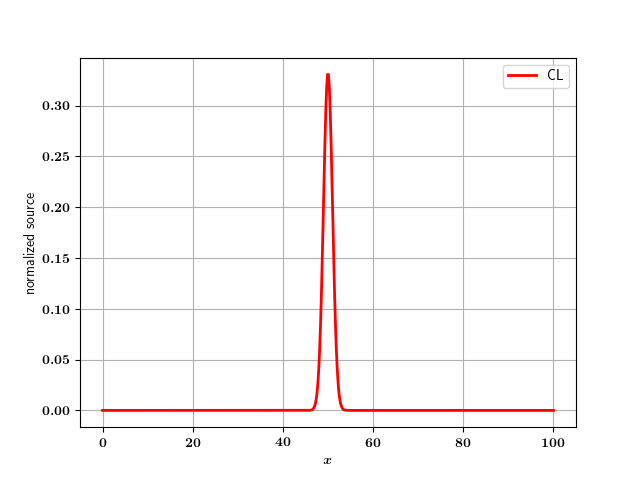

In [3]:
# ---------------------------------------------------------------
# --- Read data ---
# ---------------------------------------------------------------
mix.reload_module(ase)
def read_classical_data(name_file):
    print("Reading data from {:s}...".format(name_file))
    with h5py.File(fname, "r") as f:
        # ---
        bg          = f["basic"]
        date_sim    = bg["date-of-simulation"][()].decode("utf-8")

        # ---
        bg = f["grids"]
        x_grid = np.array(bg["x"])
        v_grid = np.array(bg["v"])
        Nx = len(x_grid)
        Nv = len(v_grid)
        nx = int(np.log2(Nx))
        nv = int(np.log2(Nv))
        
        # ---
        bg = f["profiles"]
        b_temp = np.array(bg["b"])
        
        
    # ---
    print("date of the simulation: ", date_sim)
    print("nx, nv = {:d}, {:d}".format(nx, nv))
    
    N = len(b_temp)
    
    b = np.zeros(N, dtype=complex)
    for ii in range(N):
        temp_v1 = b_temp[ii]
        b[ii] = complex(temp_v1[0], temp_v1[1])
    del b_temp, temp_v1
    
    # --- save the data ---
    dd = {
        "b": b,
        "x": x_grid, "v": v_grid,
        "N": N,
        "Nx": Nx, "Nv": Nv,
        "regs": {"rx": nx, "rv": nv}
    }
    return dd
# ----------------------------------------------------------------------------------

# --- Choose the case ---
nx_ = 9
nv_ = 6

# --- Reading data --
path_cl = "../results/KIN1D1D-results/"
fname = path_cl + "out_{:d}_{:d}_w1.2_Lx100_Lv4_flat.hdf5".format(nx_, nv_)
dd_ = read_classical_data(fname)
del path_cl, fname

# --- Extract the source from the right-hand-side vector ---
N_, Nx_, Nv_ = dd_["N"], dd_["Nx"], dd_["Nv"]
b_ = dd_["b"]
x_ = dd_["x"] 

source_  = np.zeros(Nx_, dtype=complex)
for ix in range(Nx_):
    source_[ix] = b_[Nx_*Nv_ + ix*Nv_]
coef_norm_ = np.sqrt(np.sum(np.abs(source_)**2))
print()
print("norm. of the source: {:0.3e}".format(coef_norm_))

# --- normalized source ---
source_norm_ = source_ / coef_norm_

# --- Plot the normalized source ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_, source_norm_.imag,         color='r', linewidth = 2, linestyle='-',  label = "CL")
plt.xlabel('$x$')
plt.ylabel("normalized source")
ax.legend()
plt.grid(True)
plt.show()


nx, nv: 9, 6
coef-exp: -1.249984330652e+03
ampl: 9.043146187352e-01
max-abs-err: 6.811e-06

//--- Parameters for the sin BE oracle ---
alpha_0_init 	-1.000000000000e+00
alpha_1_init 	1.001956947162e+00


norm-orig: 2.722e+00
norm-interp: 3.807e+00
norm-approx: 3.807e+00
norm-approx-interp-back: 2.721e+00


<IPython.core.display.Javascript object>


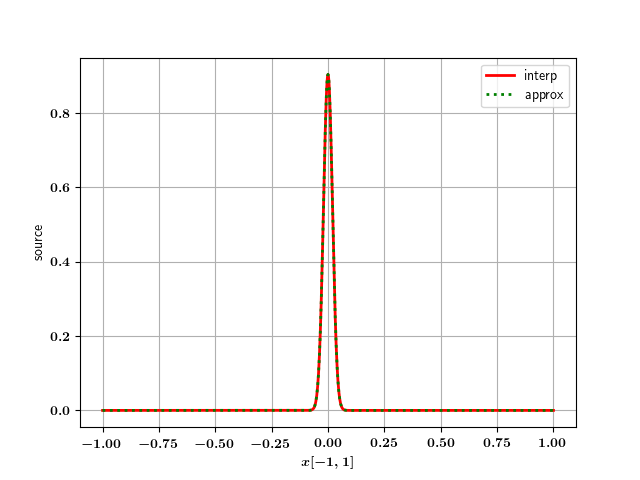

In [14]:
# -----------------------------------------------------------------------------------------------
# --- Approximate the normalized source ---
# -----------------------------------------------------------------------------------------------
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

def approx_source(x, w, a):
    return a * np.exp(w*x**2)


def find_norm(vv):
    return np.sqrt(np.sum(np.abs(vv)**2))

# ---------------------------------------------------------------------------
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline


coef_Hadamard_ = 2**(nx_/2)


# x_left = -1.0
# x_right = 1.0

x_left = -np.pi/2
x_right = np.pi/2


values_orig = source_norm_.imag / np.max(np.abs(source_norm_.imag)) * 0.9
x_grid_orig  = np.linspace(x_left, x_right, len(values_orig))
spl = CubicSpline(x_grid_orig, values_orig)

x_grid_new  = np.linspace(x_left, x_right, 1001)
values_interp = spl(x_grid_new)

pars_res, pcov = curve_fit(
    approx_source, 
    x_grid_new, values_interp, 
    p0 = [-4.0, 10.0]
#     p0 = [-4.0, 1.0]   # for [-1, 1]
)
approx_values = approx_source(x_grid_new, pars_res[0], pars_res[1])

print()
print("nx, nv: {:d}, {:d}".format(nx_, nv_))
print("coef-exp: {:0.12e}".format(pars_res[0]))
print("ampl: {:0.12e}".format(pars_res[1]))
print("max-abs-err: {:0.3e}".format(
    np.max(np.abs(
        values_interp - approx_values
    ))
))

print("\n//--- Parameters for the sin BE oracle ---")
alpha_0 = x_left
alpha_1 = 0.5 * (x_right - x_left) * Nx_ / (Nx_ - 1)

# alpha_0 = 0.0
# alpha_1 = 2. * Nx_ / (Nx_ - 1)

print("alpha_0_init \t{:0.12e}".format(alpha_0))
print("alpha_1_init \t{:0.12e}".format(alpha_1))
del alpha_0, alpha_1

# --- read coefficients ---
print()
# coef_data = qsvt_a.read_Fourier_coefs("../simulations/KIN1D1D/init-angles/", "ase-init_0.332277_6")

print()
print("norm-orig: {:0.3e}".format(find_norm(values_orig)))
print("norm-interp: {:0.3e}".format(find_norm(values_interp)))
print("norm-approx: {:0.3e}".format(find_norm(approx_values)))
print("norm-approx-interp-back: {:0.3e}".format(find_norm(
    np.interp(x_grid_orig, x_grid_new, approx_values)
)))



# --- Plot the normalized source ---
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(x_grid_orig, values_orig,   color='b', linewidth = 2, linestyle='-',  label = "orig")
ax.plot(x_grid_new,  values_interp, color='r', linewidth = 2, linestyle='-',  label = "interp")
ax.plot(x_grid_new,  approx_values, color='g', linewidth = 2, linestyle=':',  label = "approx")
# ax.plot(np.arcsin(coef_data["x"]),  coef_data["ref_funct"], color='black', linewidth = 2, linestyle=':',  label = "coefs")
plt.xlabel('$x[-1,1]$')
plt.ylabel("source")
# plt.xlim(-0.2,0.2)
ax.legend()
plt.grid(True)
plt.show()

In [ ]:
nx, nv: 8, 4
par_0: -1.249718079223e+03
par_1: 4.703339381668e-01
max-abs-err: 6.604e-05
    
    
nx, nv: 8, 5
par_0: -1.249718079223e+03
par_1: 4.703339381668e-01
max-abs-err: 6.604e-05

    
nx, nv: 9, 6
par_0: -1.249984330652e+03
par_1: 3.322768871456e-01
max-abs-err: 2.503e-06

Reading the file ../simulations/KIN1D1D//check_init_OUTPUT.hdf5...
Name of the simulation is check_init
Simulation has been performed  12-29-2023 13:44:55

0.1202773498081351
2.7215694311564786


<IPython.core.display.Javascript object>


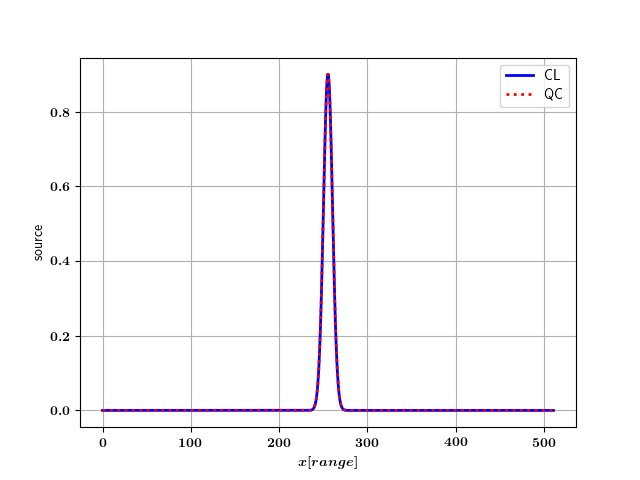

In [9]:
# -------------------------------------------------------------
# --- Read results from QuCF simulations ---
# -------------------------------------------------------------
mix.reload_module(mse)

om = mse.MeasOracle__(True)

om.path_ = "../simulations/KIN1D1D/"
om.pname_ = "check_init"
om.open()
# om.read_qsvt()

# om.set_zero_ancillae_work_states(0)
# qucf_results = om.get_var_x({}, "rx")

om.set_work_states(0)
qucf_results = om.get_var_x({"rv": 0, "a_init": 0, "a_ce": 0}, "rx")


print()
print(np.sqrt(np.sum(np.abs(qucf_results)**2)))
print(np.sqrt(np.sum(np.abs(values_orig)**2)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx_)),  values_orig,                       color='b', linewidth = 2, linestyle='-',  label = "CL")
ax.plot(np.array(range(Nx_)),  -qucf_results.real * coef_Hadamard_, color='r', linewidth = 2, linestyle=':',  label = "QC")
plt.xlabel('$x[range]$')
plt.ylabel("source")
ax.legend()
plt.grid(True)
plt.show()

In [ ]:
0.001953119715366886

In [11]:
om.set_work_states(0)

a1 = om.get_var_x({"a_init": 0, "a_ce": 0}, "rx")
print(np.sqrt(np.sum(np.abs(a1)**2)))
print(np.sqrt(np.sum(np.abs(a1 * coef_Hadamard_)**2)))

a2 = om.get_var_x({"a_init": 0, "a_ce": 1}, "rx")
print(np.sqrt(np.sum(np.abs(a2)**2)))


a3 = om.get_var_x({"a_init": 1, "a_ce": 0}, "rx")
print(np.sqrt(np.sum(np.abs(a3)**2)))

a4 = om.get_var_x({"a_init": 1, "a_ce": 1}, "rx")
print(np.sqrt(np.sum(np.abs(a4)**2)))


print(np.sqrt(np.sum(np.abs(a1)**2 + np.abs(a2)**2 + np.abs(a3)**2 + np.abs(a4)**2)))

0.1202773498081351
2.721565749519322
0.49587806819866076
0.702668657392835
0.49587806819866076
0.9999999999999944


In [ ]:
# ------------------------------------------------
# --- Plot the original right-hand-side vector ---
# ------------------------------------------------

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(
#     np.array(range(N_)), 
#     b_.real, 
#     color='b', linewidth = 2, linestyle='-')
# plt.xlabel('$i$')
# plt.ylabel("Re b")
# plt.grid(True)
# plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    np.array(range(N_)), 
    b_.imag, 
    color='b', linewidth = 2, linestyle='-')
plt.xlabel('$i$')
plt.ylabel("Im b")
# plt.xlim(Nx_*Nv_, N_)
plt.grid(True)
plt.show()